In [ ]:
!pip install statsmodels
!pip install pmdarima
%pip install folium

In [41]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import folium
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
pwd

'C:\\Users\\bmori\\OneDrive\\바탕 화면\\2-2'

In [4]:
pd.set_option('display.max_columns', 100000000000)
pd.set_option('display.max_rows', 100)

In [5]:
pd.set_option('display.max_seq_items', None)


In [2]:
#지하철 승하차 데이터 불러오기

#metro_all = pd.read_csv("C:/Users/82105/Desktop/2학년_2학기/오픈소스_개발_프로젝트/서울시 지하철 호선별 역별 시간대별 승하차 인원 정보.csv",encoding = 'cp949')
metro_all = pd.read_csv("C:/Users/bmori/OneDrive/subway/subway_people_data.csv",encoding = 'cp949')

In [3]:
#최근3년만 추출
metro_recent_c=metro_all
metro_recent_c=metro_recent_c.drop(columns={'작업일자'}) #불필요한 칼럼 제거
#사용월을 datetime으로 바꿔준다.
metro_recent_c = metro_all[(metro_all['사용월']>=202010)]
metro_recent_c['사용월'] = pd.to_datetime(metro_recent_c['사용월'].astype(str), format='%Y%m')
metro_recent_c


,사용월,호선명,지하철역,04시-05시 승차인원,04시-05시 하차인원,05시-06시 승차인원,05시-06시 하차인원,06시-07시 승차인원,06시-07시 하차인원,07시-08시 승차인원,...,23시-24시 하차인원,00시-01시 승차인원,00시-01시 하차인원,01시-02시 승차인원,01시-02시 하차인원,02시-03시 승차인원,02시-03시 하차인원,03시-04시 승차인원,03시-04시 하차인원,작업일자
0,2023-10-01,1호선,동대문,688,23,11493,2221,9618,6755,14951,...,9061,555,2415,1,221,0,0,0,0,20231103
1,2023-10-01,1호선,동묘앞,208,1,3065,1120,3652,4528,7542,...,4288,85,1680,1,318,0,0,0,0,20231103
2,2023-10-01,1호선,서울역,700,16,8826,9093,13369,60044,42194,...,14003,2333,2475,2,184,0,0,0,0,20231103
3,2023-10-01,1호선,시청,60,1,2408,5020,4325,26689,8093,...,4416,323,855,0,12,0,0,0,0,20231103
4,2023-10-01,1호선,신설동,388,18,9245,2315,9988,8178,21304,...,9543,289,2263,0,0,0,0,0,0,20231103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22594,2020-10-01,중앙선,원덕,32,0,305,9,441,135,794,...,231,1,117,0,0,0,0,0,0,20201103
22595,2020-10-01,중앙선,중랑,176,2,5954,505,8338,1956,20492,...,4325,78,974,0,0,0,0,0,0,20201103
22596,2020-10-01,중앙선,지평,0,0,0,0,0,0,292,...,0,0,0,0,0,0,0,0,0,20201103
22597,2020-10-01,중앙선,팔당,1,0,231,101,628,680,1514,...,190,23,84,0,0,0,0,0,0,20201103


In [4]:
def process_line(line, metro_recent):
    # 해당 호선 데이터 추출
    metro = metro_recent_c.groupby(['호선명','지하철역']).mean().reset_index()
    metro_line = metro[metro['호선명'] == line]
    
    # 승차 인원 컬럼 추출
    metro_get_on_devide = pd.DataFrame()  # 변수 초기화 추가
    metro_get_on_devide['지하철역'] = metro_line['지하철역']
    for i in range(int((len(metro_recent.columns)-3)/2)):
        metro_get_on_devide[metro_line.columns[3+2*i]] = metro_line[metro_line.columns[3+2*i]]
    metro_get_on_devide = metro_get_on_devide.set_index('지하철역')

    # 하차 인원 컬럼 추출
    metro_get_off = pd.DataFrame()
    metro_get_off['지하철역'] = metro_line['지하철역']
    for i in range(int((len(metro_recent.columns)-3)/2)):
        metro_get_off[metro_line.columns[4+2*i]] = metro_line[metro_line.columns[4+2*i]]
    metro_get_off = metro_get_off.set_index('지하철역')

    # 역 별 평균 승하차 인원 계산
    df = pd.DataFrame(index=metro_line['지하철역'])
    df['평균 승차 인원 수'] = metro_get_on_devide.mean(axis=1).astype('int64')
    df['평균 하차 인원 수'] = metro_get_off.mean(axis=1).astype(int)
    
    # 추가: 평균 승차 인원 수와 평균 하차 인원 수의 합계 열 추가
    df['평균 승하차 합계'] = df['평균 승차 인원 수'] + df['평균 하차 인원 수']
    
    top3_on = df.sort_values(by='평균 승차 인원 수', ascending=False).head(3)
    
    return top3_on

# 1호선부터 9호선까지 처리
result_frames = []
for line_number in range(1, 10):
    line_name = f"{line_number}호선"
    result = process_line(line_name, metro_recent_c)
    result_frames.append(result)

# 각 노선별 상위 3개의 역을 담은 데이터프레임을 생성
top3_per_line = pd.concat(result_frames, keys=[f"{i}호선" for i in range(1, 10)])
top3_per_line
# 이렇게 노션별 상위3개의 역을 알았다.

평균 승차 인원 수  평균 하차 인원 수  평균 승하차 합계
    지하철역                                          
1호선 서울역               52562       50378     102940
    종각                38456       37283      75739
    종로3가              29201       26706      55907
2호선 강남                89011       87066     176077
    잠실(송파구청)          82314       81086     163400
    홍대입구              69352       73590     142942
3호선 고속터미널             52902       51301     104203
    연신내               40971       38772      79743
    양재(서초구청)          40053       43539      83592
4호선 수유(강북구청)          38377       38281      76658
    혜화                38238       38576      76814
    쌍문                32631       30020      62651
5호선 광화문(세종문화회관)       33059       34408      67467
    까치산               32189       30866      63055
    화곡                31616       29464      61080
6호선 공덕                19779       19139      38918
    응암                19619       19423      39042
    망원                16386       17656      34042
7호선 가산디지털단지           45482       45138      90620
    학동                24626       26082      50708
    광명사거리             24467       24158      48625
8호선 문정                22005       23019      45024
    암사                20747       18461      39208
    장지                19131       18213      37344
9호선 신논현               34682       34261      68943
    노량진               29215       28706      57921
    여의도               28797       27491      56288

In [5]:

# 승하차 합계 기준으로 각 역의 합계 계산
station_totals = top3_per_line.groupby(level=0).sum()

# 상위 2개 호선 찾기
top2_lines = station_totals.nlargest(2, '평균 승하차 합계')
top2_lines

#2호선 3호선이 젤 많아!!
#그럼 이제 2,3호선의 상위3개역에 대해서만 살펴보겠다.

,평균 승차 인원 수,평균 하차 인원 수,평균 승하차 합계
2호선,240677,241742,482419
3호선,133926,133612,267538


In [6]:
#승차
metro_recent_c_geton = pd.DataFrame()
metro_recent_c_geton['호선명'] = metro_recent_c['호선명']
metro_recent_c_geton['지하철역'] = metro_recent_c['지하철역']
metro_recent_c_geton['사용월'] = metro_recent_c['사용월']
for i in range(int((len(metro_recent_c.columns)-3)/2)):  #맨처음 index는 무시하고 3,5,7,..순서대로 승차인원이므로&24개씩 승차 하차 인원이 있으므로
    metro_recent_c_geton[metro_recent_c.columns[3+2*i]] = metro_recent_c[metro_recent_c.columns[3+2*i]]
metro_recent_c_geton

,호선명,지하철역,사용월,04시-05시 승차인원,05시-06시 승차인원,06시-07시 승차인원,07시-08시 승차인원,08시-09시 승차인원,09시-10시 승차인원,10시-11시 승차인원,...,18시-19시 승차인원,19시-20시 승차인원,20시-21시 승차인원,21시-22시 승차인원,22시-23시 승차인원,23시-24시 승차인원,00시-01시 승차인원,01시-02시 승차인원,02시-03시 승차인원,03시-04시 승차인원
0,1호선,동대문,2023-10-01,688,11493,9618,14951,20657,19909,18030,...,25680,17817,15062,13799,10430,4866,555,1,0,0
1,1호선,동묘앞,2023-10-01,208,3065,3652,7542,12370,11293,13116,...,24843,10039,5844,4793,3530,1141,85,1,0,0
2,1호선,서울역,2023-10-01,700,8826,13369,42194,75501,70759,67566,...,220828,123025,89108,87580,59608,29305,2333,2,0,0
3,1호선,시청,2023-10-01,60,2408,4325,8093,11102,14674,17236,...,158616,69239,62691,53963,32319,10655,323,0,0,0
4,1호선,신설동,2023-10-01,388,9245,9988,21304,31140,22327,19391,...,49687,20869,13794,12004,8113,3693,289,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22594,중앙선,원덕,2020-10-01,32,305,441,794,861,716,822,...,671,334,148,63,32,12,1,0,0,0
22595,중앙선,중랑,2020-10-01,176,5954,8338,20492,19471,12192,8846,...,6998,4492,3183,2698,1863,920,78,0,0,0
22596,중앙선,지평,2020-10-01,0,0,0,292,155,7,337,...,61,160,1,2,0,0,0,0,0,0
22597,중앙선,팔당,2020-10-01,1,231,628,1514,1589,1225,1414,...,3614,2386,1674,1445,989,179,23,0,0,0


In [7]:
#하차
metro_recent_c_getoff = pd.DataFrame()
metro_recent_c_getoff['호선명'] = metro_recent_c['호선명']
metro_recent_c_getoff['지하철역'] = metro_recent_c['지하철역']
metro_recent_c_getoff['사용월'] = metro_recent_c['사용월']
for i in range(int((len(metro_recent_c.columns)-4)/2)):
    metro_recent_c_getoff[metro_recent_c.columns[4+2*i]] = metro_recent_c[metro_recent_c.columns[4+2*i]]
metro_recent_c_getoff

,호선명,지하철역,사용월,04시-05시 하차인원,05시-06시 하차인원,06시-07시 하차인원,07시-08시 하차인원,08시-09시 하차인원,09시-10시 하차인원,10시-11시 하차인원,...,18시-19시 하차인원,19시-20시 하차인원,20시-21시 하차인원,21시-22시 하차인원,22시-23시 하차인원,23시-24시 하차인원,00시-01시 하차인원,01시-02시 하차인원,02시-03시 하차인원,03시-04시 하차인원
0,1호선,동대문,2023-10-01,23,2221,6755,12017,20541,23460,26158,...,22333,21418,14927,13295,12184,9061,2415,221,0,0
1,1호선,동묘앞,2023-10-01,1,1120,4528,9281,21560,18828,25633,...,11845,8575,6512,6467,7088,4288,1680,318,0,0
2,1호선,서울역,2023-10-01,16,9093,60044,111515,226340,157304,85381,...,95463,66792,48809,44886,29468,14003,2475,184,0,0
3,1호선,시청,2023-10-01,1,5020,26689,70011,186809,91258,53117,...,29295,14841,9941,8943,6830,4416,855,12,0,0
4,1호선,신설동,2023-10-01,18,2315,8178,22493,52860,32651,22218,...,30045,22603,15561,15576,13190,9543,2263,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22594,중앙선,원덕,2020-10-01,0,9,135,428,699,785,904,...,616,672,415,429,235,231,117,0,0,0
22595,중앙선,중랑,2020-10-01,2,505,1956,2904,5669,4484,4177,...,20727,13780,10545,8767,6674,4325,974,0,0,0
22596,중앙선,지평,2020-10-01,0,0,0,125,368,0,446,...,44,141,3,0,0,0,0,0,0,0
22597,중앙선,팔당,2020-10-01,0,101,680,1605,2692,5097,3726,...,1907,1493,648,448,459,190,84,0,0,0


In [8]:
#시간묶기
metro_recent_c_geton['출근시간6-9']=metro_recent_c_geton.iloc[:, 5:8].sum(axis=1)
metro_recent_c_geton['점심시간11-14']=metro_recent_c_geton.iloc[:, 10:13].sum(axis=1)
metro_recent_c_geton['퇴근시간17-20']=metro_recent_c_geton.iloc[:, 16:19].sum(axis=1)
metro_recent_c_geton['야간시간22-24']=metro_recent_c_geton.iloc[:, 21:23].sum(axis=1)

#4분할만 남기고 드롭
metro_recent_c_geton_4time=metro_recent_c_geton.drop(metro_recent_c_geton.columns[3:27], axis=1)
metro_recent_c_geton_4time

,호선명,지하철역,사용월,출근시간6-9,점심시간11-14,퇴근시간17-20,야간시간22-24
0,1호선,동대문,2023-10-01,45226,72198,71973,15296
1,1호선,동묘앞,2023-10-01,23564,78579,72411,4671
2,1호선,서울역,2023-10-01,131064,277083,518332,88913
3,1호선,시청,2023-10-01,23520,80217,326434,42974
4,1호선,신설동,2023-10-01,62432,69486,110299,11806
...,...,...,...,...,...,...,...
22594,중앙선,원덕,2020-10-01,2096,2040,2022,44
22595,중앙선,중랑,2020-10-01,48301,24504,18090,2783
22596,중앙선,지평,2020-10-01,447,0,222,0
22597,중앙선,팔당,2020-10-01,3731,4926,10332,1168


In [9]:
#시간묶기
metro_recent_c_getoff['출근시간6-9']=metro_recent_c_getoff.iloc[:, 5:8].sum(axis=1)
metro_recent_c_getoff['점심시간11-14']=metro_recent_c_getoff.iloc[:, 10:13].sum(axis=1)
metro_recent_c_getoff['퇴근시간17-20']=metro_recent_c_getoff.iloc[:, 16:19].sum(axis=1)
metro_recent_c_getoff['야간시간22-24']=metro_recent_c_getoff.iloc[:, 21:23].sum(axis=1)

#4분할만 남기고 드롭
metro_recent_c_getoff_4time=metro_recent_c_getoff.drop(metro_recent_c_getoff.columns[3:27], axis=1)
metro_recent_c_getoff_4time

,호선명,지하철역,사용월,출근시간6-9,점심시간11-14,퇴근시간17-20,야간시간22-24
0,1호선,동대문,2023-10-01,39313,86251,66071,21245
1,1호선,동묘앞,2023-10-01,35369,115163,36323,11376
2,1호선,서울역,2023-10-01,397899,251946,257839,43471
3,1호선,시청,2023-10-01,283509,146698,77339,11246
4,1호선,신설동,2023-10-01,83531,60342,77606,22733
...,...,...,...,...,...,...,...
22594,중앙선,원덕,2020-10-01,1262,2565,2252,466
22595,중앙선,중랑,2020-10-01,10529,16095,47582,10999
22596,중앙선,지평,2020-10-01,493,1,186,0
22597,중앙선,팔당,2020-10-01,4977,9605,5693,649


In [10]:
#2호선 승차데이터
metro_recent_c_geton_4time_2ndline = metro_recent_c_geton_4time[metro_recent_c_geton_4time['호선명']=='2호선']

#2호선중 강남, 잠실, 홍대입구
metro_recent_c_geton_4time_2nd_line_123 = metro_recent_c_geton_4time_2ndline[
    metro_recent_c_geton_4time_2ndline['지하철역'].isin(['강남', '잠실(송파구청)', '홍대입구'])
]
metro_recent_c_geton_4time_2nd_line_123


,호선명,지하철역,사용월,출근시간6-9,점심시간11-14,퇴근시간17-20,야간시간22-24
10,2호선,강남,2023-10-01,116856,249917,732645,220645
52,2호선,잠실(송파구청),2023-10-01,323016,289048,615476,133236
59,2호선,홍대입구,2023-10-01,177562,228290,551300,275156
627,2호선,강남,2023-09-01,113285,244934,713297,219564
669,2호선,잠실(송파구청),2023-09-01,311846,267958,556111,125340
...,...,...,...,...,...,...,...
21443,2호선,잠실(송파구청),2020-11-01,287827,219032,474179,84737
21450,2호선,홍대입구,2020-11-01,152445,146248,372483,166395
22004,2호선,강남,2020-10-01,107003,221380,732822,237046
22046,2호선,잠실(송파구청),2020-10-01,273314,219080,463658,92690


In [11]:

#2호선 하차데이터
metro_recent_c_getoff_4time_2ndline = metro_recent_c_getoff_4time[metro_recent_c_getoff_4time['호선명']=='2호선']


#2호선중 강남, 잠실, 홍대입구
metro_recent_c_getoff_4time_2nd_line_123 = metro_recent_c_getoff_4time_2ndline[
    metro_recent_c_getoff_4time_2ndline['지하철역'].isin(['강남', '잠실(송파구청)', '홍대입구'])
]

metro_recent_c_getoff_4time_2nd_line_123

,호선명,지하철역,사용월,출근시간6-9,점심시간11-14,퇴근시간17-20,야간시간22-24
10,2호선,강남,2023-10-01,473405,312660,401785,60838
52,2호선,잠실(송파구청),2023-10-01,302868,376302,575669,128641
59,2호선,홍대입구,2023-10-01,165975,445131,610358,126225
627,2호선,강남,2023-09-01,470334,299000,398639,60157
669,2호선,잠실(송파구청),2023-09-01,273201,342624,549461,124336
...,...,...,...,...,...,...,...
21443,2호선,잠실(송파구청),2020-11-01,257676,249385,465063,100017
21450,2호선,홍대입구,2020-11-01,134661,254912,434960,66157
22004,2호선,강남,2020-10-01,469010,320257,423875,56832
22046,2호선,잠실(송파구청),2020-10-01,240683,252741,451434,108003


In [12]:
#3호선 승차데이터
metro_recent_c_geton_4time_3ndline = metro_recent_c_geton_4time[metro_recent_c_geton_4time['호선명']=='3호선']


#3호선중 고속터미널, 연신내, 양재(서초입구)
metro_recent_c_geton_4time_3nd_line_123 = metro_recent_c_geton_4time_3ndline[
    metro_recent_c_geton_4time_3ndline['지하철역'].isin(['고속터미널', '연신내', '양재(서초입구)'])
]

metro_recent_c_geton_4time_3nd_line_123

,호선명,지하철역,사용월,출근시간6-9,점심시간11-14,퇴근시간17-20,야간시간22-24
63,3호선,고속터미널,2023-10-01,82597,249450,412985,77320
83,3호선,연신내,2023-10-01,302921,177119,137973,27726
680,3호선,고속터미널,2023-09-01,77329,230246,387442,76361
700,3호선,연신내,2023-09-01,296752,162000,131815,27356
1296,3호선,고속터미널,2023-08-01,77368,236613,389737,70683
...,...,...,...,...,...,...,...
20871,3호선,연신내,2020-12-01,294103,126782,102474,10121
21454,3호선,고속터미널,2020-11-01,66732,175645,330110,51136
21474,3호선,연신내,2020-11-01,334412,153224,128359,24540
22057,3호선,고속터미널,2020-10-01,63605,179962,339382,60179


In [13]:
#3호선 하차데이터


metro_recent_c_getoff_4time_3ndline = metro_recent_c_getoff_4time[metro_recent_c_getoff_4time['호선명']=='3호선']


#3호선중 고속터미널, 연신내, 양재(서초입구)
metro_recent_c_getoff_4time_3nd_line_123 = metro_recent_c_getoff_4time_3ndline[
    metro_recent_c_getoff_4time_3ndline['지하철역'].isin(['고속터미널', '연신내', '양재(서초입구)'])
]

metro_recent_c_getoff_4time_3nd_line_123

,호선명,지하철역,사용월,출근시간6-9,점심시간11-14,퇴근시간17-20,야간시간22-24
63,3호선,고속터미널,2023-10-01,162058,304651,300658,37358
83,3호선,연신내,2023-10-01,72098,121432,321347,85793
680,3호선,고속터미널,2023-09-01,168590,299138,304542,39980
700,3호선,연신내,2023-09-01,70294,115316,305064,82284
1296,3호선,고속터미널,2023-08-01,158560,295027,289157,36657
...,...,...,...,...,...,...,...
20871,3호선,연신내,2020-12-01,52715,94565,287942,44435
21454,3호선,고속터미널,2020-11-01,137147,230462,257648,28634
21474,3호선,연신내,2020-11-01,64066,105991,331143,83562
22057,3호선,고속터미널,2020-10-01,134222,235768,255142,29799


---

In [14]:
# 승하차 데이터를 합친 데이터셋 .예측에 필요
metro_recent_c_total=pd.DataFrame()
metro_recent_c_total['호선명'] = metro_recent_c['호선명']
metro_recent_c_total['지하철역'] = metro_recent_c['지하철역']
metro_recent_c_total['사용월'] = metro_recent_c['사용월']
metro_recent_c_total['출근시간6-9']=metro_recent_c.iloc[:, 7:13].sum(axis=1)   
metro_recent_c_total['점심시간11-14']=metro_recent_c.iloc[:, 17:23].sum(axis=1)
metro_recent_c_total['퇴근시간17-20']=metro_recent_c.iloc[:, 29:35].sum(axis=1)
metro_recent_c_total['야간시간22-24']=metro_recent_c.iloc[:, 39:43].sum(axis=1)
metro_recent_c_total

,호선명,지하철역,사용월,출근시간6-9,점심시간11-14,퇴근시간17-20,야간시간22-24
0,1호선,동대문,2023-10-01,84539,158449,138044,36541
1,1호선,동묘앞,2023-10-01,58933,193742,108734,16047
2,1호선,서울역,2023-10-01,528963,529029,776171,132384
3,1호선,시청,2023-10-01,307029,226915,403773,54220
4,1호선,신설동,2023-10-01,145963,129828,187905,34539
...,...,...,...,...,...,...,...
22594,중앙선,원덕,2020-10-01,3358,4605,4274,510
22595,중앙선,중랑,2020-10-01,58830,40599,65672,13782
22596,중앙선,지평,2020-10-01,940,1,408,0
22597,중앙선,팔당,2020-10-01,8708,14531,16025,1817


In [17]:
#월평균승객
metro_recent_c_total['월평균승객']=metro_recent_c_total.iloc[:,3:].mean(axis=1)
metro_recent_c_total

,호선명,지하철역,사용월,출근시간6-9,점심시간11-14,퇴근시간17-20,야간시간22-24,월평균승객
0,1호선,동대문,2023-10-01,84539,158449,138044,36541,104393.25
1,1호선,동묘앞,2023-10-01,58933,193742,108734,16047,94364.00
2,1호선,서울역,2023-10-01,528963,529029,776171,132384,491636.75
3,1호선,시청,2023-10-01,307029,226915,403773,54220,247984.25
4,1호선,신설동,2023-10-01,145963,129828,187905,34539,124558.75
...,...,...,...,...,...,...,...,...
22594,중앙선,원덕,2020-10-01,3358,4605,4274,510,3186.75
22595,중앙선,중랑,2020-10-01,58830,40599,65672,13782,44720.75
22596,중앙선,지평,2020-10-01,940,1,408,0,337.25
22597,중앙선,팔당,2020-10-01,8708,14531,16025,1817,10270.25


In [18]:
#2호선의 top3 강남, 잠실(송파구청), 홍대입구역만 추출해서 시각화
metro_line2_top1=metro_recent_c_total[(metro_recent_c_total['지하철역']=='강남') & (metro_recent_c_total['호선명']=='2호선')]
metro_line2_top1
metro_line2_top2=metro_recent_c_total[(metro_recent_c_total['지하철역']=='잠실(송파구청)') & (metro_recent_c_total['호선명']=='2호선')]
metro_line2_top2
metro_line2_top3=metro_recent_c_total[(metro_recent_c_total['지하철역']=='홍대입구') & (metro_recent_c_total['호선명']=='2호선')]
metro_line2_top3

,호선명,지하철역,사용월,출근시간6-9,점심시간11-14,퇴근시간17-20,야간시간22-24,월평균승객
59,2호선,홍대입구,2023-10-01,343537,673421,1161658,401381,644999.25
676,2호선,홍대입구,2023-09-01,325527,604851,1083730,385776,599971.00
1292,2호선,홍대입구,2023-08-01,331840,652365,1104224,390661,619772.50
1908,2호선,홍대입구,2023-07-01,335378,672601,1128928,413242,637537.25
2524,2호선,홍대입구,2023-06-01,343571,633569,1084964,411166,618317.50
3138,2호선,홍대입구,2023-05-01,350782,644670,1127759,413510,634180.25
3752,2호선,홍대입구,2023-04-01,346553,616825,1105234,398155,616691.75
4365,2호선,홍대입구,2023-03-01,361650,630759,1179666,413571,646411.50
4982,2호선,홍대입구,2023-02-01,300813,601898,1061409,367336,582864.00
5595,2호선,홍대입구,2023-01-01,303763,581521,1033795,360746,569956.25


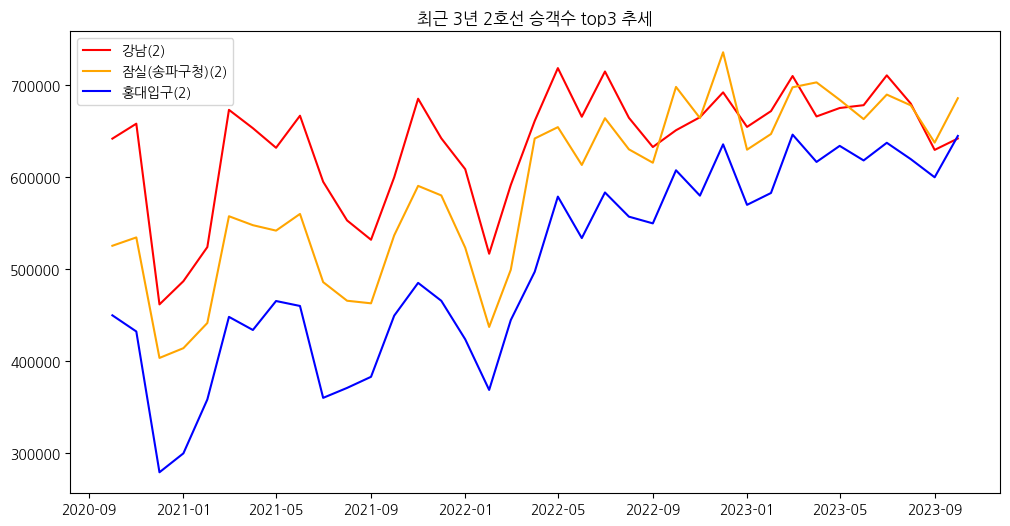

In [19]:
#2호선 top3역 3년간 승하차 평균 월별로 나타냄

#폰트 깨짐 해결
from matplotlib import font_manager, rc

#font_path = "C:/Users/82105/Desktop/2학년_2학기/오픈소스_개발_프로젝트/나눔 글꼴/나눔고딕/NanumFontSetup_TTF_GOTHIC/NanumGothic.ttf"
font_path= "C:/Users/bmori/OneDrive/subway/NanumGothic.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name) 


plt.figure(figsize=(12,6))
plt.title('최근 3년 2호선 승객수 top3 추세')
plt.plot(metro_line2_top1['사용월'],metro_line2_top1['월평균승객'],color='red', label='강남(2)')
plt.plot(metro_line2_top2['사용월'],metro_line2_top2['월평균승객'],color='orange', label='잠실(송파구청)(2)')
plt.plot(metro_line2_top3['사용월'],metro_line2_top3['월평균승객'],color='blue',label='홍대입구(2)')
plt.legend()
plt.show()


In [20]:
#3호선의 top3 고속터미널, 연신내, 양재(서초구청)역만 추출해서 시각화
metro_line3_top1=metro_recent_c_total[(metro_recent_c_total['지하철역']=='고속터미널') & (metro_recent_c_total['호선명']=='3호선')]
metro_line3_top1
metro_line3_top2=metro_recent_c_total[(metro_recent_c_total['지하철역']=='연신내') & (metro_recent_c_total['호선명']=='3호선')]
metro_line3_top2
metro_line3_top3=metro_recent_c_total[(metro_recent_c_total['지하철역']=='양재(서초구청)') & (metro_recent_c_total['호선명']=='3호선')]
metro_line3_top3

,호선명,지하철역,사용월,출근시간6-9,점심시간11-14,퇴근시간17-20,야간시간22-24,월평균승객
82,3호선,양재(서초구청),2023-10-01,452939,254283,578584,90545,344087.75
699,3호선,양재(서초구청),2023-09-01,441393,240966,554514,86599,330868.00
1315,3호선,양재(서초구청),2023-08-01,468505,228720,581576,85899,341175.00
1931,3호선,양재(서초구청),2023-07-01,479018,244188,591358,92033,351649.25
2547,3호선,양재(서초구청),2023-06-01,484545,251551,598167,95723,357496.50
3161,3호선,양재(서초구청),2023-05-01,483669,259096,595590,97203,358889.50
3775,3호선,양재(서초구청),2023-04-01,477576,258830,589902,92243,354637.75
4388,3호선,양재(서초구청),2023-03-01,515515,264326,639255,99626,379680.50
5005,3호선,양재(서초구청),2023-02-01,445434,245467,574836,88649,338596.50
5618,3호선,양재(서초구청),2023-01-01,437679,232197,560039,86938,329213.25


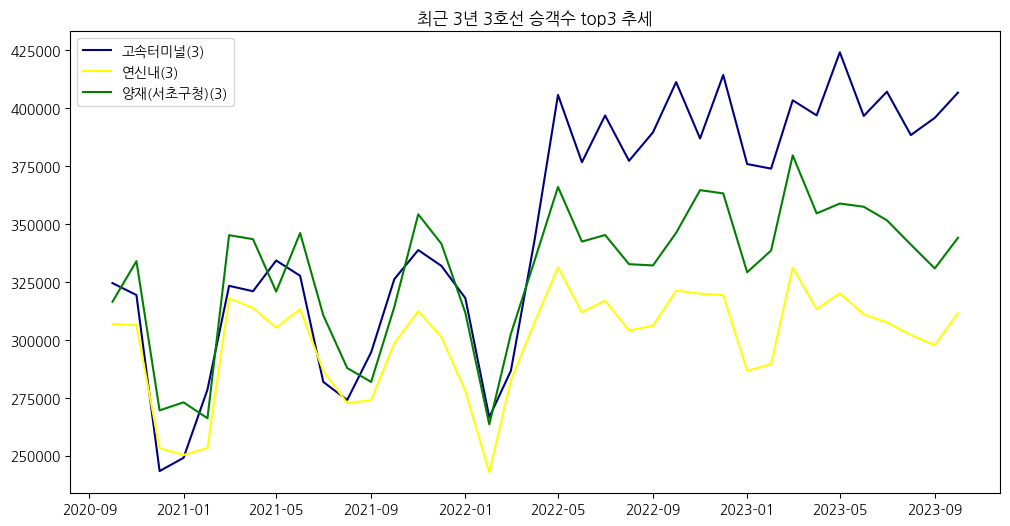

In [21]:
#3호선 top3역 3년간 승하차 평균 월별로 나타냄

#폰트 깨짐 해결
#font_path = "C:/Users/82105/Desktop/2학년_2학기/오픈소스_개발_프로젝트/나눔 글꼴/나눔고딕/NanumFontSetup_TTF_GOTHIC/NanumGothic.ttf"
font_path= "C:/Users/bmori/OneDrive/subway/NanumGothic.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name) 


plt.figure(figsize=(12,6))
plt.title('최근 3년 3호선 승객수 top3 추세')
plt.plot(metro_line3_top1['사용월'],metro_line3_top1['월평균승객'],color='navy', label='고속터미널(3)')
plt.plot(metro_line3_top2['사용월'],metro_line3_top2['월평균승객'],color='yellow', label='연신내(3)')
plt.plot(metro_line3_top3['사용월'],metro_line3_top3['월평균승객'],color='green', label='양재(서초구청)(3)')
plt.legend()
plt.show()

---
### 강남역 예측 모델

---

In [25]:
# 예측도구(SARIMA) 임포트
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf #(p,q)의 차수를 결정하기 위해
from statsmodels.tsa.seasonal import seasonal_decompose      #ETS 분해를 위해
from pmdarima import auto_arima                              #자동 ARIMA 사용을 위해
#자동 ARIMA(자동회귀누적이동평균)모델
#자기 회귀-현재 값이 이전 값들의 선형조합으로 표현됨을 나타냄.p는 이전 값들의 개수
#현재의 값이 과거의 값들에 의존한다는 가정
#yt=c+ϕ1yt−1+ϕ2yt−2+⋯+ϕpyt−p+εt,      ϕ는 각각의 과거 값에 대한 가중치,εt는 모델의 오차항 

#누적 이동 평균-새로운 값이 들어올 때마다 평균을 최신화함
#차분-추세와 계절성을 제거

# 평가도구 임포트
from sklearn.metrics import mean_squared_error #평균과 데이터의 차를 제곱후 합함
from statsmodels.tools.eval_measures import rmse #위 값의 제곱근을 구함

### 1.a 원본 데이터 플롯으로 그리기(계절성, 추세 확인)

In [22]:
#인덱스는 datetime으로 강남역의 월평균승객 데이터프레임 생성
metro_line2_top1_pred=pd.DataFrame()
metro_line2_top1_pred['사용월']=metro_line2_top1['사용월']
metro_line2_top1_pred['월평균승객']=metro_line2_top1['월평균승객']
metro_line2_top1_pred.set_index('사용월',inplace=True)
metro_line2_top1_pred

,월평균승객
사용월,
2023-10-01,642187.75
2023-09-01,629802.50
2023-08-01,680279.25
2023-07-01,710963.50
2023-06-01,678488.25
2023-05-01,675409.75
2023-04-01,666222.50
2023-03-01,710239.50
2023-02-01,672018.75


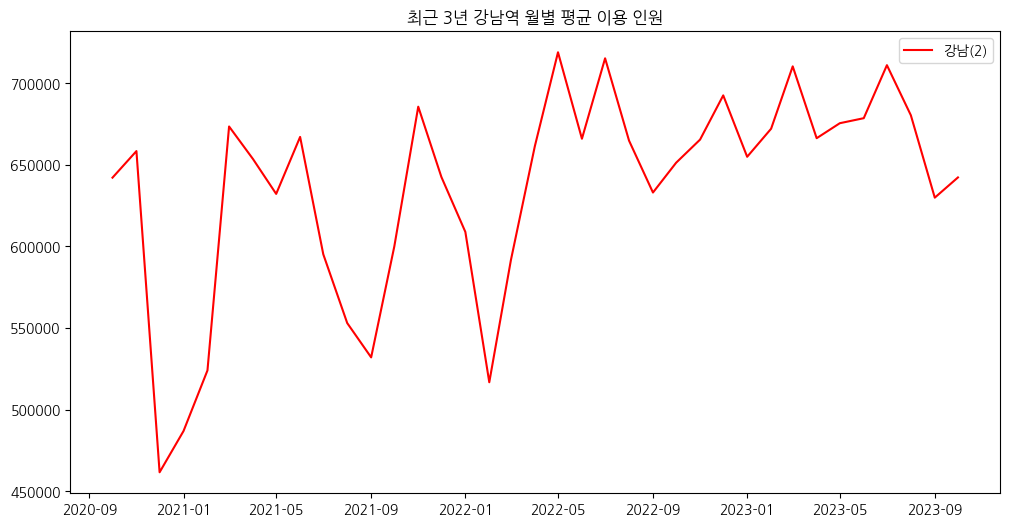

In [23]:
#강남역의 최근 3년간 월별 승객수 시각화
plt.figure(figsize=(12,6))
plt.title('최근 3년 강남역 월별 평균 이용 인원')
plt.plot(metro_line2_top1_pred['월평균승객'],color='red', label='강남(2)')
plt.legend() #그래프의 주석 표시
plt.show()

### 1.b ETS 분해

ETS(Errobous-Trend-Seasonal) 분해는 시계열 데이터를    
추세(Trend)   
계절성(Seasonal)   
오차(Error)         세 가지 구성 요소로 분해하는 분석 방법

파이썬 라이브러리 statsmodels.tsa.seasonal을 통해 실행 

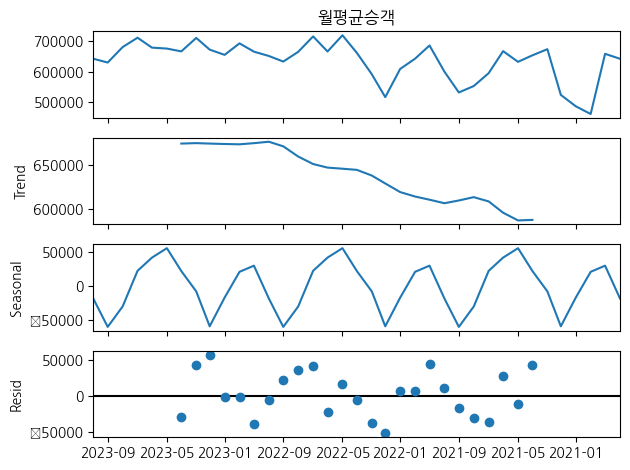

In [26]:
#ETS 분해
result = seasonal_decompose(metro_line2_top1_pred['월평균승객'], model='add')
result.plot();

### 1.c 자동ARIMA로 추천모델 도출.

In [27]:
auto_arima(metro_line2_top1_pred['월평균승객'],seasonal=True,m=12).summary()
#계절성주기를 12(1년 12개월) 입력하여 SARIMAX를 결정받는다.
#seasonal=True 는 계절성을 갖음을 나타냄
#SARIMAX(0,1,0)을 추천

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   37
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -447.212
Date:                Sat, 25 Nov 2023   AIC                            896.424
Time:                        13:56:55   BIC                            898.008
Sample:                             0   HQIC                           896.977
                                 - 37                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.512e+09   5.78e+08      6.073      0.000    2.38e+09    4.65e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 6.88
Prob(Q):                              0.79   Prob(JB):                         0.03
Heteroskedasticity (H):               7.14   Skew:                             0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 1.d 훈련 데이터셋과 테스트데이터셋으로 분리.

In [28]:
train = metro_line2_top1_pred.iloc[len(metro_line2_top1_pred)-24:]       #3년전부터 1년전까지
test = metro_line2_top1_pred.iloc[:len(metro_line2_top1_pred)-24]      #1년전부터 올해

### 1.e 자동 ARIMA가 제공하는 차수를 통해 예측값을 얻는다.

In [29]:
model = SARIMAX(train['월평균승객'],order=(0,1,0),seasonal_order=(1,0,0,12),trend='t')
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              월평균승객   No. Observations:                   24
Model:             SARIMAX(0, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -289.602
Date:                            Sat, 25 Nov 2023   AIC                            585.204
Time:                                    13:57:09   BIC                            588.610
Sample:                                         0   HQIC                           586.060
                                             - 24                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift        144.9375    899.965      0.161      0.872   -1618.961    1908.836
ar.S.L12      -0.0709      0.232     -0.305      0.760      -0.526       0.385
sigma2       5.16e+09      0.000   2.42e+13      0.000    5.16e+09    5.16e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 1.54
Prob(Q):                              0.78   Prob(JB):                         0.46
Heteroskedasticity (H):               2.18   Skew:                             0.38
Prob(H) (two-sided):                  0.29   Kurtosis:                         4.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.01e+28. Standard errors may be unstable.
"""

### 1.f 예측값과 테스트값을 플롯에 표기

In [30]:
start=len(train)
end=len(train)+len(test)-1

predictions = results.predict(start=start, end=end, dynamic=False, typ='levels')
#구하려는값이 차분되는 값인지 실제값인지를 결정하는 파라미터
predictions

24    650353.146371
25    652486.010464
26    653266.787904
27    652083.788735
28    658616.781436
29    661307.668443
30    664240.290102
31    679326.491317
32    686596.693314
33    693171.352805
34    684150.531150
35    690377.147234
36    695006.749288
Name: predicted_mean, dtype: float64

In [31]:
#인덱스 달아주기(예측값이 데이터 프레임이 아니기 때문에)

data=predictions
dates = ['2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01',
         '2023-02-01','2023-03-01','2023-04-01','2023-05-01',
         '2023-06-01','2023-07-01','2023-08-01','2023-09-01','2023-10-01']
predictions_df = pd.DataFrame(data.values, index=pd.to_datetime(dates))
predictions_df.reset_index(inplace=True)
predictions_df.rename(columns={'index':'사용월',0:'예측값'}, inplace=True)
predictions_df.set_index('사용월',inplace=True)
predictions_df

,예측값
사용월,
2022-10-01,650353.146371
2022-11-01,652486.010464
2022-12-01,653266.787904
2023-01-01,652083.788735
2023-02-01,658616.781436
2023-03-01,661307.668443
2023-04-01,664240.290102
2023-05-01,679326.491317
2023-06-01,686596.693314


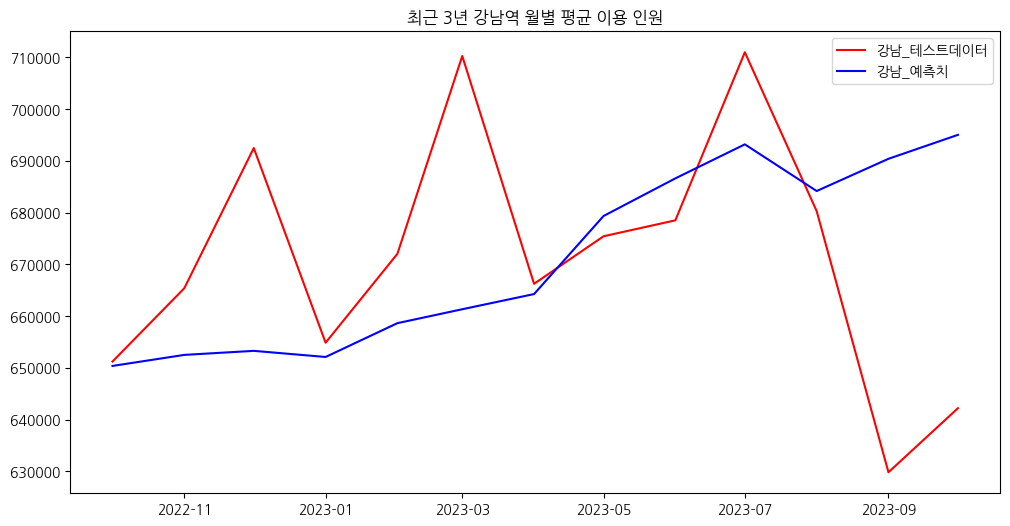

In [32]:
#예측치와 test 데이터 비교
plt.figure(figsize=(12,6))
plt.title('최근 3년 강남역 월별 평균 이용 인원')
plt.plot(test['월평균승객'],color='red', label='강남_테스트데이터')
plt.plot(predictions_df['예측값'],color='blue', label='강남_예측치')
plt.legend()
plt.show()

### 1.g 평균제곱근 오차를 통해 모델 평가

In [33]:
#test데이터의 평균
test['월평균승객'].mean()

671498.2115384615

In [34]:
#평균 제곱근 오차
error = rmse(test['월평균승객'], predictions_df['예측값'])
print(f'평균 제곱근 오차: {error:11.10}')

#오차 = (28,590/671,498)*100 = 4.25%

평균 제곱근 오차: 28590.61488


오차가   
(28,590/671,498)*100 = 4.25% 로 구해짐

### 2. 이후 1년 후 데이터를 예측한다.

In [35]:
model = SARIMAX(metro_line2_top1_pred['월평균승객'],order=(1,1,0),seasonal_order=(1,0,0,12), trend='t')
results = model.fit()
fcast = results.predict(len(metro_line2_top1_pred),len(metro_line2_top1_pred)+11,typ='levels').rename('미래_예측값')

In [36]:
#미래_예측값 데이터프레임 만들기
data=fcast
dates = ['2023-11-01', '2023-12-01', '2024-01-01',
         '2024-02-01','2024-03-01','2024-04-01','2024-05-01',
         '2024-06-01','2024-07-01','2024-08-01','2024-09-01','2024-10-01']
predictions_fcast = pd.DataFrame(data.values, index=pd.to_datetime(dates))
predictions_fcast.reset_index(inplace=True)
predictions_fcast.rename(columns={'index':'사용월',0:'미래_예측값'}, inplace=True)
predictions_fcast.set_index('사용월',inplace=True)
predictions_fcast

,미래_예측값
사용월,
2023-11-01,642017.787033
2023-12-01,643042.802026
2024-01-01,644435.346690
2024-02-01,646324.651855
2024-03-01,646513.593682
2024-04-01,647625.914526
2024-05-01,648734.561608
2024-06-01,647135.484413
2024-07-01,647361.880789


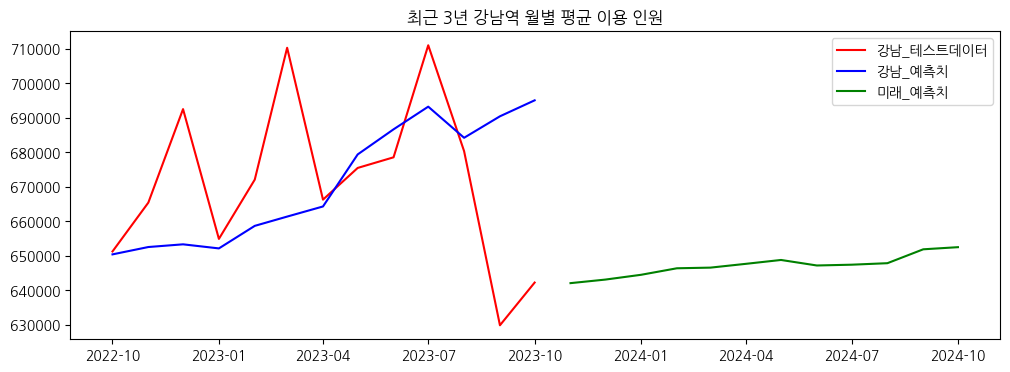

In [37]:
#미래_예측치
plt.figure(figsize=(12,4))
plt.title('최근 3년 강남역 월별 평균 이용 인원')
plt.plot(test['월평균승객'],color='red', label='강남_테스트데이터')
plt.plot(predictions_df['예측값'],color='blue', label='강남_예측치')
plt.plot(predictions_fcast['미래_예측값'],color='green', label='미래_예측치')
plt.legend()
plt.show()

---
### 새로운 노선 그리기

---

1~9호선까지 승객 승하차 상위 3개역씩 뽑아서 지도에 표시

지하철 역의 좌표 csv
출처: https://developers.kakao.com/docs/latest/ko/local/dev-guide#address-coord

In [38]:
#지하철 좌표 CSV 읽어오기
#subway_location_c = pd.read_csv("C:/Users/82105/Desktop/2학년_2학기/오픈소스_개발_프로젝트/지하철_승하차_인원_분석/지하철 역 위치 좌표.csv")
subway_location_c = pd.read_csv('./subway_location.csv')
subway_location_c.drop(columns={'주소'}, inplace=True)
subway_location_c.drop_duplicates(subset=['지하철역'], inplace=True)
subway_location_c.reset_index(drop=True)

#좌표없는 곳 (서울역) 서울역 좌표 추가해주기
seoul_station={'지하철역': ['서울역'],'x좌표': [37.554722],'y좌표':[126.970833]}
seoul_location=pd.DataFrame(seoul_station)
subway_location_c=pd.concat([subway_location_c,seoul_location], ignore_index=True)
subway_location_c


,지하철역,x좌표,y좌표
0,4.19민주묘지역,37.649457,127.013506
1,가능역,37.747906,127.044358
2,가락시장역,37.492915,127.118215
3,가산디지털단지역,37.482414,126.882240
4,가양역,37.561758,126.853997
...,...,...,...
521,회룡역,37.713908,127.046619
522,회현역,37.557688,126.976720
523,효창공원앞역,37.539622,126.960984
524,흑석역,37.508502,126.964009


In [39]:
#최근 3년간 지하철 노선별 승하차인원이 제일 많은 역을 리스트로 추출
top3_per_line_list = top3_per_line.index.get_level_values('지하철역').tolist()
top3_per_line_list_mean = top3_per_line['평균 승하차 합계'].tolist()

#좌표 데이터셋의 지하철역 이름을 맞추기 위해 ()를 없애준다.
top3_per_line_list=[station.replace('잠실(송파구청)', '잠실') for station in top3_per_line_list]
top3_per_line_list=[station.replace('양재(서초구청)', '양재') for station in top3_per_line_list]
top3_per_line_list=[station.replace('수유(강북구청)', '수유') for station in top3_per_line_list]
top3_per_line_list=[station.replace('광화문(세종문화회관)', '광화문') for station in top3_per_line_list]


#좌표를 사용하기 위해 마지막에 '역' 붙여주기
for i in range(1,len(top3_per_line_list)):
    top3_per_line_list[i] += '역'

In [40]:
#최근 3년간 지하철 노선별 승하차인원이 제일 많은 역의 좌표정보를 담은 데이터 프레임.
top3_per_line_location=pd.DataFrame()
top3_per_line_location['지하철역']=top3_per_line_list
top3_per_line_location = pd.merge(top3_per_line_location, subway_location_c, on='지하철역', how='left')
top3_per_line_location['평균 승하차 합계']=top3_per_line_list_mean
top3_per_line_location

,지하철역,x좌표,y좌표,평균 승하차 합계
0,서울역,37.554722,126.970833,102940
1,종각역,37.570233,126.981416,75739
2,종로3가역,37.570517,126.991117,55907
3,강남역,37.497057,127.028181,176077
4,잠실역,37.514063,127.102052,163400
5,홍대입구역,37.556890,126.923674,142942
6,고속터미널역,37.504850,127.004875,104203
7,연신내역,37.618933,126.920853,79743
8,양재역,37.484779,127.033384,83592
9,수유역,37.639822,127.027223,76658


In [43]:
# 서울의 중심에 위치하는 명동역의 위도와 경도를 중심으로 지도 출력합니다.
latitude = subway_location_c[subway_location_c['지하철역']=='명동역']['x좌표'] #위도설정
longitude = subway_location_c[subway_location_c['지하철역']=='명동역']['y좌표'] #경도설정
map_osm = folium.Map(location = [latitude, longitude], zoom_start = 11)

# 각 지하철 역의 위치 별로 마커를 지도에 추가
for i in top3_per_line_location.index:
    marker = folium.CircleMarker([top3_per_line_location['x좌표'][i],top3_per_line_location['y좌표'][i]],
                       radius = (top3_per_line_location['평균 승하차 합계'][i]+1)/15000, # 인원 수가 0일 때 계산오류 보정
                        popup = [top3_per_line_location['지하철역'][i],top3_per_line_location['평균 승하차 합계'][i]], 
                        color = 'blue', 
                        fill_color = 'blue')
    marker.add_to(map_osm)
map_osm

---
### 강남역 2호선 통과하는 지하철 횟수

---

### 현재

강남역 배차간격 약 4분.   
한시간에 15회   
하루에 18*15=270회 (첫차 06시 막차 00시)  

In [44]:
gangnam_passger=metro_line2_top1['월평균승객'].mean()
gangnam_passger

635462.6216216217

최근 3년동안 하루 평균 강남역 승하차 인원 =  635,462명  

In [45]:
gangnam_passger/270

2353.565265265265

따라서 지하철 한 차량에 이용하는 승객은 635,462/270 = 2,353.6 (명/회) 

---
### 노선 추가 이후

강남역에 한 시간에 2회를 추가로 운행하는 노선이 만들어진다는 가정하에   
한시간에 17회   
하루에 18*17회=306회

In [46]:
gangnam_passger/(306)

2076.675234057587

따라서 지하철 한 차량에 이용하는 승객은 635,462/306=2076.7 (명/회)

##  2,353.6 (명/회) -> 2076.7 (명/회)   
## 혼잡율 약 12%감소!

추가로 대기시간과 대기인원의 감소로 혼잡도는 더 크게 감소한다고 체감할 수 있을 것이다.

---

# 4번 지하철 근무요원 효율적 배치 파트


In [48]:
#먼저 승차 데이터와 하차 데이터를 합친다.
metro_combined = pd.merge(metro_recent_c_geton_4time, metro_recent_c_getoff_4time, on=['호선명', '지하철역', '사용월'], suffixes=('_승차', '_하차'))
metro_combined


,호선명,지하철역,사용월,출근시간6-9_승차,점심시간11-14_승차,퇴근시간17-20_승차,야간시간22-24_승차,출근시간6-9_하차,점심시간11-14_하차,퇴근시간17-20_하차,야간시간22-24_하차
0,1호선,동대문,2023-10-01,45226,72198,71973,15296,39313,86251,66071,21245
1,1호선,동묘앞,2023-10-01,23564,78579,72411,4671,35369,115163,36323,11376
2,1호선,서울역,2023-10-01,131064,277083,518332,88913,397899,251946,257839,43471
3,1호선,시청,2023-10-01,23520,80217,326434,42974,283509,146698,77339,11246
4,1호선,신설동,2023-10-01,62432,69486,110299,11806,83531,60342,77606,22733
...,...,...,...,...,...,...,...,...,...,...,...
22594,중앙선,원덕,2020-10-01,2096,2040,2022,44,1262,2565,2252,466
22595,중앙선,중랑,2020-10-01,48301,24504,18090,2783,10529,16095,47582,10999
22596,중앙선,지평,2020-10-01,447,0,222,0,493,1,186,0
22597,중앙선,팔당,2020-10-01,3731,4926,10332,1168,4977,9605,5693,649


In [49]:
#역별로 그룹화한다음 날짜별 승객수를 평균을 낸다.
metro_combined_grouped = metro_combined.groupby(['호선명', '지하철역']).mean().reset_index()
metro_combined_grouped


,호선명,지하철역,사용월,출근시간6-9_승차,점심시간11-14_승차,퇴근시간17-20_승차,야간시간22-24_승차,출근시간6-9_하차,점심시간11-14_하차,퇴근시간17-20_하차,야간시간22-24_하차
0,1호선,동대문,2022-04-01 11:01:37.297297408,40202.756757,60196.216216,62891.918919,13132.081081,38715.783784,67950.108108,55589.594595,17788.648649
1,1호선,동묘앞,2022-04-01 11:01:37.297297408,18917.378378,60142.378378,58480.000000,4383.756757,32863.837838,85350.459459,30020.864865,8293.324324
2,1호선,서울역,2022-04-01 11:01:37.297297408,108850.351351,198123.756757,419052.378378,62366.432432,324800.432432,186306.756757,207564.081081,33226.594595
3,1호선,시청,2022-04-01 11:01:37.297297408,18138.972973,57810.324324,268296.567568,32359.405405,250952.054054,95869.432432,51684.756757,6676.054054
4,1호선,신설동,2022-04-01 11:01:37.297297408,52022.459459,57647.081081,109130.972973,10988.081081,87267.054054,53578.432432,66175.459459,17265.324324
...,...,...,...,...,...,...,...,...,...,...,...
621,중앙선,원덕,2022-04-01 11:01:37.297297408,2329.648649,2045.189189,1667.405405,28.270270,1173.162162,2064.891892,2381.702703,537.837838
622,중앙선,중랑,2022-04-01 11:01:37.297297408,51248.297297,24899.108108,18641.486486,2734.594595,11035.540541,16907.270270,51008.459459,12434.351351
623,중앙선,지평,2022-04-01 11:01:37.297297408,551.189189,83.324324,357.270270,9.324324,426.405405,126.486486,534.756757,54.567568
624,중앙선,팔당,2022-04-01 11:01:37.297297408,3435.405405,4101.864865,8041.378378,941.000000,5137.945946,7003.378378,4667.216216,694.000000


###  이로서 각각의 지하철역당 시간대별로 승차가 많은지 하차가 많은지 확인할수 있고 이를 이용해 에스칼레이터나 개찰구 방향변경을 이용해 트래픽을 줄일수있다.

In [ ]:
#출근시간 승차,하차/ 점심시간 승차,하차/ 퇴근시간 승차,하차 야간시간 승차,하차 순으로 열을 변경한다.
# 기존 데이터프레임에서 열 선택하여 새로운 데이터프레임 생성
new_order = ['호선명', '지하철역', '출근시간6-9_승차', '출근시간6-9_하차', '점심시간11-14_승차', '점심시간11-14_하차', '퇴근시간17-20_승차', '퇴근시간17-20_하차', '야간시간22-24_승차', '야간시간22-24_하차']

# 새로운 순서로 데이터프레임 생성
metro_combined_grouped_reordered = metro_combined_grouped[new_order]

# 결과 출력
metro_combined_grouped_reordered.style.background_gradient()


### 시간대별로 데이터 각각 추출

In [30]:
morning_rush_hour = metro_combined_grouped_reordered[['호선명', '지하철역', '출근시간6-9_승차', '출근시간6-9_하차']]
lunch_time = metro_combined_grouped_reordered[['호선명', '지하철역', '점심시간11-14_승차', '점심시간11-14_하차']]
evening_rush_hour = metro_combined_grouped_reordered[['호선명', '지하철역', '퇴근시간17-20_승차', '퇴근시간17-20_하차']]
night_time = metro_combined_grouped_reordered[['호선명', '지하철역', '야간시간22-24_승차', '야간시간22-24_하차']]

# 결과 출력
print("출근시간6-9")
print(morning_rush_hour)

print("\n점심시간11-14")
print(lunch_time)

print("\n퇴근시간17-20")
print(evening_rush_hour)

print("\n야간시간22-24")
print(night_time)



출근시간6-9
     호선명 지하철역     출근시간6-9_승차     출근시간6-9_하차
0    1호선  동대문   40202.756757   38715.783784
1    1호선  동묘앞   18917.378378   32863.837838
2    1호선  서울역  108850.351351  324800.432432
3    1호선   시청   18138.972973  250952.054054
4    1호선  신설동   52022.459459   87267.054054
..   ...  ...            ...            ...
621  중앙선   원덕    2329.648649    1173.162162
622  중앙선   중랑   51248.297297   11035.540541
623  중앙선   지평     551.189189     426.405405
624  중앙선   팔당    3435.405405    5137.945946
625  중앙선   회기  141794.702703   89503.972973

[626 rows x 4 columns]

점심시간11-14
     호선명 지하철역   점심시간11-14_승차   점심시간11-14_하차
0    1호선  동대문   60196.216216   67950.108108
1    1호선  동묘앞   60142.378378   85350.459459
2    1호선  서울역  198123.756757  186306.756757
3    1호선   시청   57810.324324   95869.432432
4    1호선  신설동   57647.081081   53578.432432
..   ...  ...            ...            ...
621  중앙선   원덕    2045.189189    2064.891892
622  중앙선   중랑   24899.108108   16907.270270
623  중앙선   지평      83.324324     

### 시간대별로 나누어진 데이터프레임을 총승객수가 많은 순으로 정렬한다. 
### 출근시간대 데이터 프레임:morning_rush_hour_sorted
### 점심시간대 데이터 프레임: lunch_time_sorted
### 퇴근시간대 데이터 프레임: evening_rush_hour_sorted
### 야간시간대 데이터 프레임: night_time_sorted

In [31]:
# 출근시간6-9
morning_rush_hour_sorted = morning_rush_hour.groupby(['호선명', '지하철역']).sum().assign(총인원=lambda x: x['출근시간6-9_승차'] + x['출근시간6-9_하차']).sort_values(by=['호선명', '총인원'], ascending=[True, False]).reset_index()

# 점심시간11-14
lunch_time_sorted = lunch_time.groupby(['호선명', '지하철역']).sum().assign(총인원=lambda x: x['점심시간11-14_승차'] + x['점심시간11-14_하차']).sort_values(by=['호선명', '총인원'], ascending=[True, False]).reset_index()

# 퇴근시간17-20
evening_rush_hour_sorted = evening_rush_hour.groupby(['호선명', '지하철역']).sum().assign(총인원=lambda x: x['퇴근시간17-20_승차'] + x['퇴근시간17-20_하차']).sort_values(by=['호선명', '총인원'], ascending=[True, False]).reset_index()

# 야간시간22-24
night_time_sorted = night_time.groupby(['호선명', '지하철역']).sum().assign(총인원=lambda x: x['야간시간22-24_승차'] + x['야간시간22-24_하차']).sort_values(by=['호선명', '총인원'], ascending=[True, False]).reset_index()

# 결과 출력
print("출근시간6-9")
print(morning_rush_hour_sorted)

print("\n점심시간11-14")
print(lunch_time_sorted)

print("\n퇴근시간17-20")
print(evening_rush_hour_sorted)

print("\n야간시간22-24")
print(night_time_sorted)


출근시간6-9
     호선명          지하철역     출근시간6-9_승차     출근시간6-9_하차            총인원
0    1호선           서울역  108850.351351  324800.432432  433650.783784
1    1호선            종각   18326.810811  338121.864865  356448.675676
2    1호선            시청   18138.972973  250952.054054  269091.027027
3    1호선  청량리(서울시립대입구)   93634.675676   69635.243243  163269.918919
4    1호선          종로5가   15743.918919  147404.783784  163148.702703
..   ...           ...            ...            ...            ...
621  중앙선            아신    3861.378378    1785.027027    5646.405405
622  중앙선            원덕    2329.648649    1173.162162    3502.810811
623  중앙선            오빈    2161.648649    1243.270270    3404.918919
624  중앙선            신원     951.837838    1159.837838    2111.675676
625  중앙선            지평     551.189189     426.405405     977.594595

[626 rows x 5 columns]

점심시간11-14
     호선명          지하철역   점심시간11-14_승차   점심시간11-14_하차            총인원
0    1호선           서울역  198123.756757  186306.756757  384430.513514
1    

### 지도에 표시하기위해 folium import

In [40]:
# 특정 위도, 경도 중심으로 하는 OpenStreetMap을 출력
map_osm = folium.Map(location = [37.539622, 126.960984], zoom_start=12)
map_osm

In [41]:
# 지하철 역별 위치좌표에 대한 데이터를 불러온다.
subway_location = pd.read_csv('./subway_location.csv')
subway_location

,지하철역,주소,x좌표,y좌표
0,4.19민주묘지역,서울 강북구 우이동 72-182,37.649457,127.013506
1,가능역,경기 의정부시 가능동 197-1,37.747906,127.044358
2,가락시장역,서울 송파구 가락동 184-23,37.492915,127.118215
3,가산디지털단지역,서울 금천구 가산동 468-4,37.482414,126.882240
4,가양역,서울 강서구 가양동 14-61,37.561758,126.853997
...,...,...,...,...
574,회룡역,경기 의정부시 호원동 50-5,37.713908,127.046619
575,회현역,서울 중구 남창동 64-1,37.557688,126.976720
576,회현역,서울 중구 남창동 64-1,37.557688,126.976720
577,효창공원앞역,서울 용산구 효창동 80,37.539622,126.960984


### 특정역 지역데이터 추출 정의

In [42]:
def get_nums_and_location_by_time(line, data, time_col):
    # 특정 호선과 시간대의 데이터 추출
    line_data = data[data['호선명'] == line]
    
    # 역 별 평균 승하차 인원을 구한 후 정수로 형 변환하여 데이터프레임으로 저장합니다.
    df = line_data.groupby(['지하철역']).mean().reset_index()
    df[f'평균 {time_col}_승차'] = df[f'{time_col}_승차'].astype(int)
    df[f'평균 {time_col}_하차'] = df[f'{time_col}_하차'].astype(int)
    
    # 지하철역 명 동일하도록 설정합니다.
    temp = []
    df = df.reset_index()
    for name in df['지하철역']:
        temp.append(name.split('(')[0]+'역')
    df['지하철역'] = temp
    
    # 지하철역 명을 기준으로 두 데이터프레임 병합합니다.
    df = df.merge(subway_location, left_on='지하철역', right_on='지하철역')
    
    return df

# Get data for '2호선' during morning rush hours
morning_data = get_nums_and_location_by_time('2호선', morning_rush_hour_sorted, '출근시간6-9')

# 서울의 중심에 위치하는 명동역의 위도와 경도를 중심으로 지도 출력합니다.
latitude = subway_location[subway_location['지하철역'] == '효창공원앞역']['x좌표'].values[0]  # 위도 설정
longitude = subway_location[subway_location['지하철역'] == '효창공원앞역']['y좌표'].values[0]  # 경도 설정
map_osm = folium.Map(location=[latitude, longitude], zoom_start=16)

# 각 지하철 역의 위치별로 원형마커를 지도에 추가합니다.
for i in morning_data.index:
    marker = folium.CircleMarker([morning_data['y좌표'][i], morning_data['x좌표'][i]],
                                 radius=(morning_data['평균 출근시간6-9_승차'][i] + 1) / 3000,
                                 popup=[morning_data['지하철역'][i], morning_data['평균 출근시간6-9_승차'][i]],
                                 color='blue',
                                 fill_color='blue')
    marker.add_to(map_osm)

# Display the map
map_osm


# '2호선', morning_rush_hour_sorted, '출근시간6-9')

In [61]:
import folium

# 명동역의 위도와 경도를 확인합니다.
latitude_myeongdong = subway_location[subway_location['지하철역'] == '명동역']['x좌표'].values[0]
longitude_myeongdong = subway_location[subway_location['지하철역'] == '명동역']['y좌표'].values[0]

# Get data for '2호선' during morning rush hours
morning_data = get_nums_and_location_by_time('2호선', morning_rush_hour_sorted, '출근시간6-9')

# 서울의 중심에 위치하는 명동역의 위도와 경도를 중심으로 지도 출력합니다.
map_osm = folium.Map(location=[latitude_myeongdong, longitude_myeongdong], zoom_start=12)

# 각 지하철 역의 위치별로 원형마커를 지도에 추가합니다.
for i in morning_data.index:
    # 승차 원형 마커 추가
    marker = folium.CircleMarker([morning_data['x좌표'][i], morning_data['y좌표'][i]],
                                 radius=(morning_data['평균 출근시간6-9_승차'][i] + 1) / 20000,
                                 popup=[morning_data['지하철역'][i], morning_data['평균 출근시간6-9_승차'][i]],
                                 color='blue',  # 승차는 녹색으로 표시
                                 fill_color='blue',
                                 fill_opacity=0.7)
    marker.add_to(map_osm)

    # 하차 원형 마커 추가
    marker = folium.CircleMarker([morning_data['x좌표'][i], morning_data['y좌표'][i]],
                                 radius=(morning_data['평균 출근시간6-9_하차'][i] + 1) / 20000,
                                 popup=[morning_data['지하철역'][i], morning_data['평균 출근시간6-9_하차'][i]],
                                 color='red',  # 하차는 빨간색으로 표시
                                 fill_color='red',
                                 fill_opacity=0.7)
    marker.add_to(map_osm)

# Display the map
map_osm



## '2호선', evening_rush_hour_sorted, '퇴근시간 17-20')


In [60]:
import folium

# 명동역의 위도와 경도를 확인합니다.
latitude_myeongdong = subway_location[subway_location['지하철역'] == '명동역']['x좌표'].values[0]
longitude_myeongdong = subway_location[subway_location['지하철역'] == '명동역']['y좌표'].values[0]

# Get data for '2호선' during evening rush hours
evening_data = get_nums_and_location_by_time('2호선', evening_rush_hour_sorted, '퇴근시간17-20')

# 서울의 중심에 위치하는 명동역의 위도와 경도를 중심으로 지도 출력합니다.
map_osm = folium.Map(location=[latitude_myeongdong, longitude_myeongdong], zoom_start=12)

# 각 지하철 역의 위치별로 원형마커를 지도에 추가합니다.
for i in evening_data.index:
    # 퇴근시간 승차 원형 마커 추가
    marker = folium.CircleMarker([evening_data['x좌표'][i], evening_data['y좌표'][i]],
                                 radius=(evening_data['평균 퇴근시간17-20_승차'][i] + 1) / 20000,
                                 popup=[evening_data['지하철역'][i], evening_data['평균 퇴근시간17-20_승차'][i]],
                                 color='blue',  # 퇴근시간 승차는 파란색으로 표시
                                 fill_color='blue',
                                 fill_opacity=0.7)
    marker.add_to(map_osm)

    # 퇴근시간 하차 원형 마커 추가
    marker = folium.CircleMarker([evening_data['x좌표'][i], evening_data['y좌표'][i]],
                                 radius=(evening_data['평균 퇴근시간17-20_하차'][i] + 1) / 20000,
                                 popup=[evening_data['지하철역'][i], evening_data['평균 퇴근시간17-20_하차'][i]],
                                 color='red',  # 퇴근시간 하차는 삘긴섹으로 표시
                                 fill_color='red',
                                 fill_opacity=0.7)
    marker.add_to(map_osm)

# Display the map
map_osm

